In [1]:
# os.chdir("hmr4d/")
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from hmr4d.network.gvhmr.relative_transformer import NetworkEncoderRoPE
from hmr4d.model.gvhmr.utils.endecoder import EnDecoder
from hmr4d.model.gvhmr.pipeline.gvhmr_pipeline import get_smpl_params_w_Rt_v2
from hmr4d.model.gvhmr.utils.postprocess import (
    pp_static_joint,
    process_ik,
    pp_static_joint_cam,
)

from hmr4d.utils.preproc import Tracker, Extractor, VitPoseExtractor, SimpleVO
from hmr4d.utils.geo.hmr_cam import get_bbx_xys_from_xyxy, estimate_K, create_camera_sensor
from hmr4d.utils.geo.hmr_cam import compute_bbox_info_bedlam, compute_transl_full_cam, normalize_kp2d
from hmr4d.utils.geo_transform import compute_cam_angvel, move_to_start_point_face_z
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.video_io_utils import get_writer
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, get_ground_params_from_points
from hmr4d.utils.vis.cv2_utils import draw_bbx_xyxy_on_image_batch, draw_kpts_with_conf_batch

/home/guangyu/anaconda3/envs/hmr/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
denoiser3d = NetworkEncoderRoPE().eval().cuda()
endecoder = EnDecoder(stats_name="MM_V1_AMASS_LOCAL_BEDLAM_CAM").eval().cuda()

cam_angvel_mean = torch.tensor([1., 0., 0., 0., 1., 0.], device='cuda')
cam_angvel_std = torch.tensor( [1e-3, 0.1, 0.1, 0.1, 1e-3, 0.1], device='cuda')

state_dict = torch.load('inputs/checkpoints/gvhmr/gvhmr_siga24_release.ckpt')['state_dict']
transf_state_dict = {key.replace("pipeline.denoiser3d.", ""): value for key, value in state_dict.items() if "pipeline.denoiser3d." in key}
denoiser3d.load_state_dict(transf_state_dict)

tracker = Tracker()
vitpose_extractor = VitPoseExtractor()
extractor = Extractor()

[12/19 21:11:26][INFO] [EnDecoder] Use MM_V1_AMASS_LOCAL_BEDLAM_CAM for statistics!


### 1. parse_args_to_cfg

In [3]:
# demo.py -> L41~55
video_path = Path("inputs/falltest/falltest4-rotate.mp4")
output_root = Path("outputs/falltest")
output_root.mkdir(parents=True, exist_ok=True)
static_cam = False
use_dpvo = False
f_mm = None

# demo.py -> L60
# hmr4d.utils.video_io_utils.get_video_lwh
length, height, width, c = iio.improps(video_path, plugin="pyav").shape
if length == 0:
    video = cv2.VideoCapture(str(video_path))
    fps = video.get(cv2.CAP_PROP_FPS)
    length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))-1
print(f"{str(video_path)}: {width}x{height}x{length}")

inputs/falltest/falltest4-rotate.mp4: 960x540x150


### 2. Run Preprocess

In [4]:
# bbx_xyxy = tracker.get_one_track(video_path, track_id=107).float()  # (L, 4)
# # bbx_xyxy = tracker.get_one_track(video_path, imgsize=960, track_id=1, print_res=True).float()
# bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

In [5]:
track_history = tracker.track(video_path)
vid_length = len(track_history)
id_to_frame_ids, id_to_bbx_xyxys, id_sorted = tracker.sort_track_length(track_history, video_path)

for k in id_sorted:
    lst = id_to_frame_ids[k]
    ranges = np.split(lst, np.where(np.diff(lst)!=1)[0]+1)
    ranges = [(x[0], x[-1]) if len(x) > 1 else (x[0], x[0]) for x in ranges]
    print(f"track id {k}: {len(lst)} frames, ranges: {ranges}")

YoloV8 Tracking: 100%|██████████| 150/150 [00:03<00:00, 49.92it/s]

track id 1: 111 frames, ranges: [(0, 81), (86, 86), (90, 90), (92, 93), (97, 99), (104, 107), (109, 119), (131, 131), (144, 149)]


In [6]:
track_id = 1
frame_ids = torch.tensor(id_to_frame_ids[track_id])  # (N,)
bbx_xyxys = torch.tensor(id_to_bbx_xyxys[track_id])  # (N, 4)

# track_id = 2
# frame_ids_2 = torch.tensor(id_to_frame_ids[track_id])  # (N,)
# bbx_xyxys_2 = torch.tensor(id_to_bbx_xyxys[track_id])  # (N, 4)
# frame_ids = torch.cat([frame_ids, frame_ids_2])
# bbx_xyxys = torch.cat([bbx_xyxys, bbx_xyxys_2])

bbx_xyxy = tracker.interpolate_smooth_bbx(frame_ids, bbx_xyxys, length=vid_length)
bbx_xys = get_bbx_xys_from_xyxy(bbx_xyxy, base_enlarge=1.2).float()

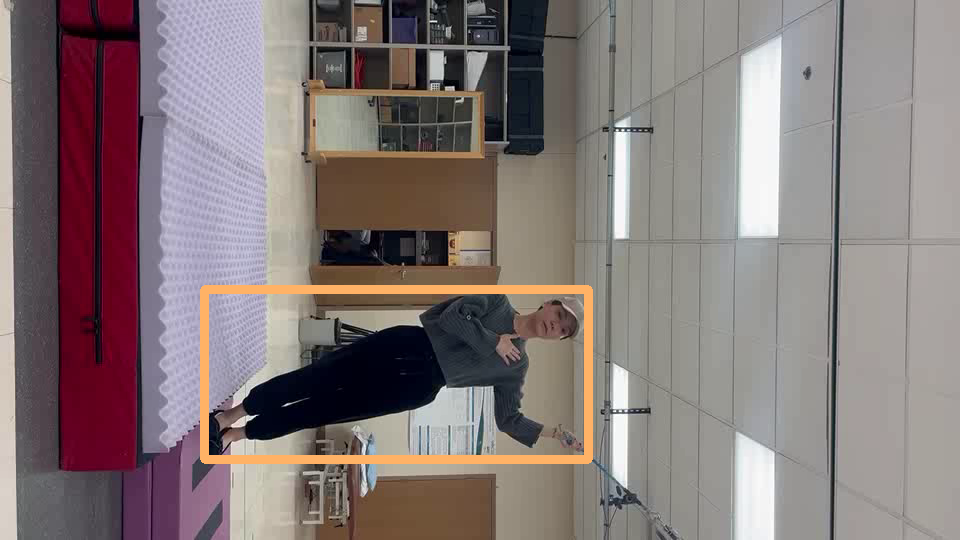

In [7]:
i = 50
img = iio.imread(video_path, index=i)  # (L, H, W, 3) RGB
video_overlay = draw_bbx_xyxy_on_image_batch(bbx_xyxy[i:i+1], [img], thickness=8)
Image.fromarray(video_overlay[0])

In [8]:
vitpose = vitpose_extractor.extract(str(video_path), bbx_xys) # (L, 17, 3)
vit_features = extractor.extract_video_features(str(video_path), bbx_xys) # (L, 1024)

ViTPose:   0%|          | 0/10 [00:00<?, ?it/s]

HMR2 Feature: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


In [9]:
# demo.py -> 151~152

simple_vo = SimpleVO(video_path, scale=0.5, step=8, method="sift", f_mm=None)
vo_results = simple_vo.compute() # (L, 4, 4)
R_w2c = torch.from_numpy(vo_results[:, :3, :3]) # (L, 3, 3)
K_fullimg = estimate_K(width, height).repeat(length, 1, 1) # (L, 3, 3)

[SimpleVO] Choosen frames shape: (20, 270, 480, 3)
TwoViewGeometryOptions:
    min_num_inliers = 10
    min_E_F_inlier_ratio = 0.8
    max_H_inlier_ratio = 0.9
    watermark_min_inlier_ratio = 0.7
    watermark_border_size = 0.1
    detect_watermark = True
    multiple_ignore_watermark = True
    watermark_detection_max_error = 4.0
    filter_stationary_matches = False
    stationary_matches_max_error = 4.0
    force_H_use = False
    compute_relative_pose = True
    multiple_models = False
    ransac: RANSACOptions:
        max_error = 4.0
        min_inlier_ratio = 0.25
        confidence = 0.999
        dyn_num_trials_multiplier = 3.0
        min_num_trials = 100
        max_num_trials = 10000
        random_seed = -1


100%|██████████| 19/19 [00:01<00:00, 18.25it/s]


### 3. Model Inference

In [9]:
cliff_cam = compute_bbox_info_bedlam(bbx_xys[None], K_fullimg[None]).to('cuda')  # (B, L, 3)
f_cam_angvel = compute_cam_angvel(R_w2c).to('cuda')
f_condition = {
    "obs": normalize_kp2d(vitpose, bbx_xys)[None].to('cuda'),  # (B, L, J, 3)
    "f_cliffcam": cliff_cam,  # (B, L, 3)
    "f_cam_angvel": (f_cam_angvel - cam_angvel_mean) / cam_angvel_std,  # (B, L, C=6)
    "f_imgseq": vit_features[None].to('cuda'),  # (B, L, C=1024)
}

In [10]:
with torch.no_grad():
    model_output = denoiser3d(length=torch.tensor([length], device='cuda'), **f_condition)  # pred_x, pred_cam, static_conf_logits
    decode_dict = endecoder.decode(model_output["pred_x"]) 

In [11]:
outputs = {}
# Post-processing
outputs["pred_smpl_params_incam"] = {
    "body_pose": decode_dict["body_pose"],  # (B, L, 63)
    "betas": decode_dict["betas"],  # (B, L, 10)
    "global_orient": decode_dict["global_orient"],  # (B, L, 3)
    "transl": compute_transl_full_cam(
        model_output["pred_cam"], bbx_xys.to('cuda'), K_fullimg.to('cuda')),
}

pred_smpl_params_global = get_smpl_params_w_Rt_v2(  # This function has for-loop
    global_orient_gv=decode_dict["global_orient_gv"],
    local_transl_vel=decode_dict["local_transl_vel"],
    global_orient_c=decode_dict["global_orient"],
    cam_angvel=f_cam_angvel[None],
)
outputs["pred_smpl_params_global"] = {
    "body_pose": decode_dict["body_pose"],
    "betas": decode_dict["betas"],
    **pred_smpl_params_global,
}
outputs["static_conf_logits"] = model_output["static_conf_logits"]

if static_cam:  # extra post-processing to utilize static camera prior
    outputs["pred_smpl_params_global"]["transl"] = pp_static_joint_cam(outputs, endecoder)
else:
    outputs["pred_smpl_params_global"]["transl"] = pp_static_joint(outputs, endecoder)

body_pose = process_ik(outputs, endecoder)
decode_dict["body_pose"] = body_pose
outputs["pred_smpl_params_global"]["body_pose"] = body_pose
outputs["pred_smpl_params_incam"]["body_pose"] = body_pose

pred = {
    "smpl_params_global": {k: v[0] for k, v in outputs["pred_smpl_params_global"].items()},
    "smpl_params_incam": {k: v[0] for k, v in outputs["pred_smpl_params_incam"].items()},
}

In [12]:
final_results = {
    "bbx_xyxy": bbx_xyxy, "bbx_xys": bbx_xys,
    "vitpose": vitpose,
    'vit_features': vit_features,
    'vo_results': vo_results,
    'K_fullimg': K_fullimg,
    'smpl_params_global' :pred["smpl_params_global"],
    'smpl_params_incam' :pred["smpl_params_incam"],
    'static_conf_logits': outputs['static_conf_logits'][0]
}
torch.save(final_results, output_root / f"{video_path.stem}.pt")

### 4. Render InCamera View

In [13]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).cuda()
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).cuda()
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").cuda()
faces_smpl = smpl.faces
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").cuda()

r_width, r_height = width, height # 
# r_width, r_height = width//4, height//4

In [14]:
# smpl
renderer_c = Renderer(r_width, r_height, device="cuda", faces=faces_smpl, K=estimate_K(r_width, r_height))

smplx_out = smplx(**pred["smpl_params_incam"])
pred_c_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_out.vertices])
pred_c_joints, pred_c_valid = renderer_c.project_points_to_full_image(smplx_out.joints)

In [15]:
smplx_out = smplx(**pred["smpl_params_global"])
pred_ay_verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_out.vertices])

pred_gb_verts, pred_gb_joints = move_to_start_point_face_z(pred_ay_verts, J_regressor)

global_R, global_T, global_lights = get_global_cameras_static(
    pred_gb_joints.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0,
)
_, _, K = create_camera_sensor(r_width, r_height, 24)
renderer_g = Renderer(r_width, r_height, device="cuda", faces=faces_smpl, K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(pred_gb_joints[:, 0], pred_gb_verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8


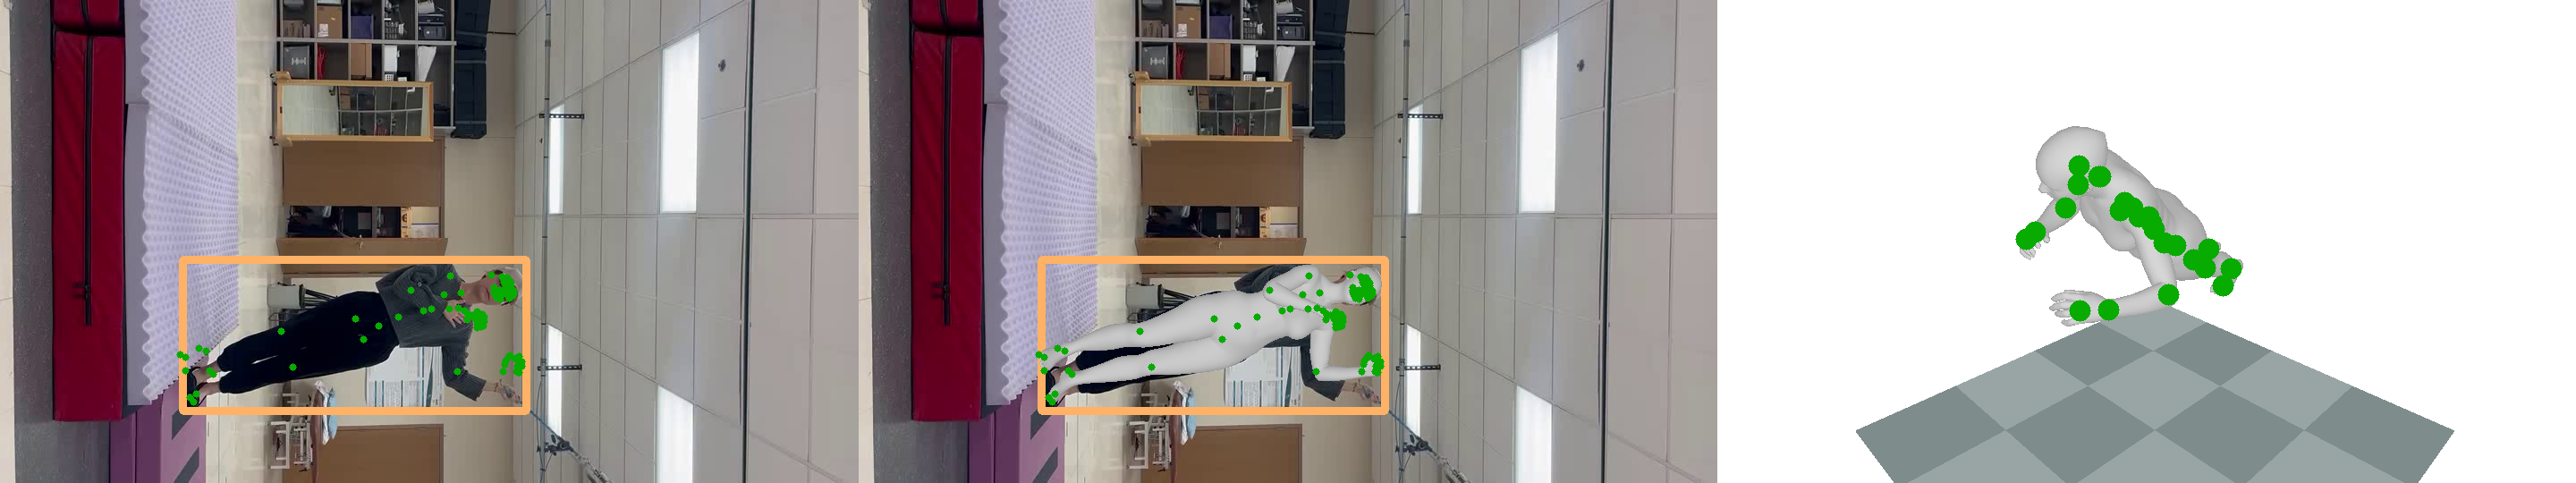

In [16]:
i = 25

img_raw = cv2.resize(iio.imread(video_path, index=i), (r_width, r_height))
img_raw = draw_bbx_xyxy_on_image_batch(bbx_xyxy[i:i+1], [img_raw], thickness=8)[0]
img_raw = draw_kpts_with_conf_batch([img_raw], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

img_cam = renderer_c.render_mesh(pred_c_verts[i].cuda(), img_raw, [0.8, 0.8, 0.8])
img_cam = draw_kpts_with_conf_batch([img_cam], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

cameras = renderer_g.create_camera(global_R[i], global_T[i])
img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)
tmp_joints, tmp_valid = renderer_g.project_points_to_full_image(pred_gb_joints[i:i+1], cameras=cameras, world_space=True)
img_gb = draw_kpts_with_conf_batch([img_gb], tmp_joints, tmp_valid, thickness=12)[0]

Image.fromarray(np.concatenate([img_raw, img_cam, img_gb], axis=1))

In [17]:
writer = get_writer(output_root / f'{video_path.stem}.mp4', fps=30, crf=23)
for i in tqdm(range(length), desc=f"Rendering Global"):
    img_raw = cv2.resize(iio.imread(video_path, index=i), (r_width, r_height))
    img_raw = draw_bbx_xyxy_on_image_batch(bbx_xyxy[i:i+1], [img_raw], thickness=8)[0]
    img_raw = draw_kpts_with_conf_batch([img_raw], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

    img_cam = renderer_c.render_mesh(pred_c_verts[i].cuda(), img_raw, [0.8, 0.8, 0.8])
    img_cam = draw_kpts_with_conf_batch([img_cam], pred_c_joints[i:i+1], pred_c_valid[i:i+1], thickness=4)[0]

    cameras = renderer_g.create_camera(global_R[i], global_T[i])
    img_gb = renderer_g.render_with_ground(pred_gb_verts[[i]], color[None], cameras, global_lights)
    tmp_joints, tmp_valid = renderer_g.project_points_to_full_image(pred_gb_joints[i:i+1], cameras=cameras, world_space=True)
    img_gb = draw_kpts_with_conf_batch([img_gb], tmp_joints, tmp_valid, thickness=12)[0]

    img = np.concatenate([img_raw, img_cam, img_gb], axis=1)
    writer.write_frame(img)
writer.close()

Rendering Global: 100%|██████████| 150/150 [00:10<00:00, 14.57it/s]


In [ ]:
B, L, J, C = obs.shape
assert J == 17 and C == 3

# Main token from observation (2D pose)
obs = obs.clone()
visible_mask = obs[..., [2]] > 0.5  # (B, L, J, 1)
obs[~visible_mask[..., 0]] = 0  # set low-conf to all zeros
f_obs = self.learned_pos_linear(obs[..., :2])  # (B, L, J, 32)
f_obs = f_obs * visible_mask + self.learned_pos_params.repeat(B, L, 1, 1) * ~visible_mask
x = self.embed_noisyobs(f_obs.view(B, L, -1))  # (B, L, J*32) -> (B, L, C)

# Condition
f_to_add = []
f_to_add.append(self.cliffcam_embedder(f_cliffcam))
f_to_add.append(self.cam_angvel_embedder(f_cam_angvel))
f_to_add.append(self.imgseq_embedder(f_imgseq))

for f_delta in f_to_add:
    x = x + f_delta

# Setup length and make padding mask
assert B == length.size(0)
pmask = ~length_to_mask(length, L)  # (B, L)

if L > self.max_len:
    attnmask = torch.ones((L, L), device=x.device, dtype=torch.bool)
    for i in range(L):
        min_ind = max(0, i - self.max_len // 2)
        max_ind = min(L, i + self.max_len // 2)
        max_ind = max(self.max_len, max_ind)
        min_ind = min(L - self.max_len, min_ind)
        attnmask[i, min_ind:max_ind] = False
else:
    attnmask = None

# Transformer
for block in self.blocks:
    x = block(x, attn_mask=attnmask, tgt_key_padding_mask=pmask)

# Output
sample = self.final_layer(x)  # (B, L, C)
betas = (sample[..., 126:136] * (~pmask[..., None])).sum(1) / length[:, None]  # (B, C)
betas = repeat(betas, "b c -> b l c", l=L)
sample = torch.cat([sample[..., :126], betas, sample[..., 136:]], dim=-1)

# Output (extra)
pred_cam = self.pred_cam_head(x)
pred_cam = pred_cam * self.pred_cam_std + self.pred_cam_mean
torch.clamp_min_(pred_cam[..., 0], 0.25)  # min_clamp s to 0.25 (prevent negative prediction)
static_conf_logits = self.static_conf_head(x)  # (B, L, C')

output = {
    "pred_context": x,
    "pred_x": sample,
    "pred_cam": pred_cam,
    "static_conf_logits": static_conf_logits,
}